In [ ]:
## load the packages

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import hydrant.topology.river_graph as rg
import subprocess
import os


In [2]:
# set the path to MERIT-Basins

In [3]:
# input paths
mb_path = '/Users/shg096/Desktop/MERIT_Hydro/cat/'
rv_path = '/Users/shg096/Desktop/MERIT_Hydro/riv/'

mb_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
rv_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'

# output paths
path_out = '/home/shg096/scratch/Bow_at_Calgary/domain/'
#path_out = '/Users/shg096/Desktop/FHIMP/output/'
#os.makedirs(path_out)

In [4]:
# preparing the target pfaf areas for manupulation

In [5]:
pfafs = ['71']#, '72']

# Define the file name templates with a placeholder *
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

cat_files = []
riv_files = []

for pafaf in pfafs:
    # Replace * with the current pafaf value
    cat_files.append(cat_file_template.replace('*', pafaf))
    riv_files.append(riv_file_template.replace('*', pafaf))

# reading in data and append
cat = pd.concat([gpd.read_file(os.path.join(mb_path, f)) for f in cat_files])
riv = pd.concat([gpd.read_file(os.path.join(rv_path, f)) for f in riv_files])

cat.set_crs(epsg=4326, inplace=True, allow_override=True)
riv.set_crs(epsg=4326, inplace=True, allow_override=True)


,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,geometry
0,71000001,7.020492,4.158236,1.688334,0.000570,391.901537,2,0.0,0.000000,71000065,2,71000095,71000213,0,0,"LINESTRING (-98.06167 60.00000, -98.06250 59.9..."
1,71000002,24.171249,15.709184,1.538670,0.000058,701.754912,2,1.4,0.000058,71000065,2,71000003,71000014,0,0,"LINESTRING (-98.06167 60.00000, -98.06083 60.0..."
2,71000003,14.760464,11.209022,1.316838,0.000770,480.760660,2,11.4,0.000770,71000002,2,71000004,71000011,0,0,"LINESTRING (-98.17250 60.13000, -98.17333 60.1..."
3,71000004,6.240078,4.631999,1.347168,0.000911,388.938962,2,5.7,0.000911,71000003,2,71000005,71000015,0,0,"LINESTRING (-98.33500 60.07000, -98.33583 60.0..."
4,71000005,4.462477,3.338111,1.336827,0.000670,328.557527,2,3.0,0.000670,71000004,2,71000006,71000012,0,0,"LINESTRING (-98.39917 60.09667, -98.40000 60.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48946,71048947,1.498642,1.192443,1.256782,0.000333,32.277067,1,0.5,0.000333,71048442,0,0,0,0,0,"LINESTRING (-96.79000 45.95583, -96.79083 45.9..."
48947,71048948,2.743329,1.941526,1.412975,0.001674,52.472792,1,4.6,0.001674,71048857,0,0,0,0,0,"LINESTRING (-96.90500 45.95500, -96.90583 45.9..."
48948,71048949,9.357690,5.642147,1.658534,0.000171,76.116685,1,1.6,0.000171,71048338,0,0,0,0,0,"LINESTRING (-97.72083 45.99500, -97.72000 45.9..."
48949,71048950,12.016268,9.919203,1.211415,0.001511,43.278839,1,18.2,0.001511,71048880,0,0,0,0,0,"LINESTRING (-96.25667 45.96417, -96.25583 45.9..."


<AxesSubplot:>

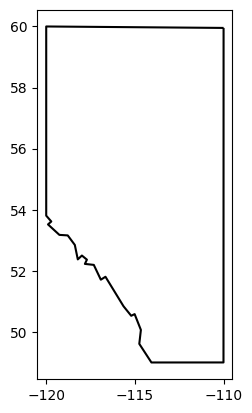

In [17]:
# Manupulate target shapefile if desired or exists (this is optional)
trg_shp = gpd.read_file('../../data/province/provinces.shp')
sel_pr = ['Quebec', 'New Brunswick', 'Nova Scotia', 'Prince Edward Island']
sel_pr = ['Nova Scotia', 'Prince Edward Island']
sel_pr = ['Alberta']
# subsetting `provinces` variable
trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)
trg_provinces.boundary.plot(color='k')

In [7]:
cat, riv = gm.intersect_topology(cat=cat,\
                                 cat_cols={'id':'COMID'},\
                                 riv=riv,\
                                 riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                 shapefile=trg_provinces)



<AxesSubplot:>

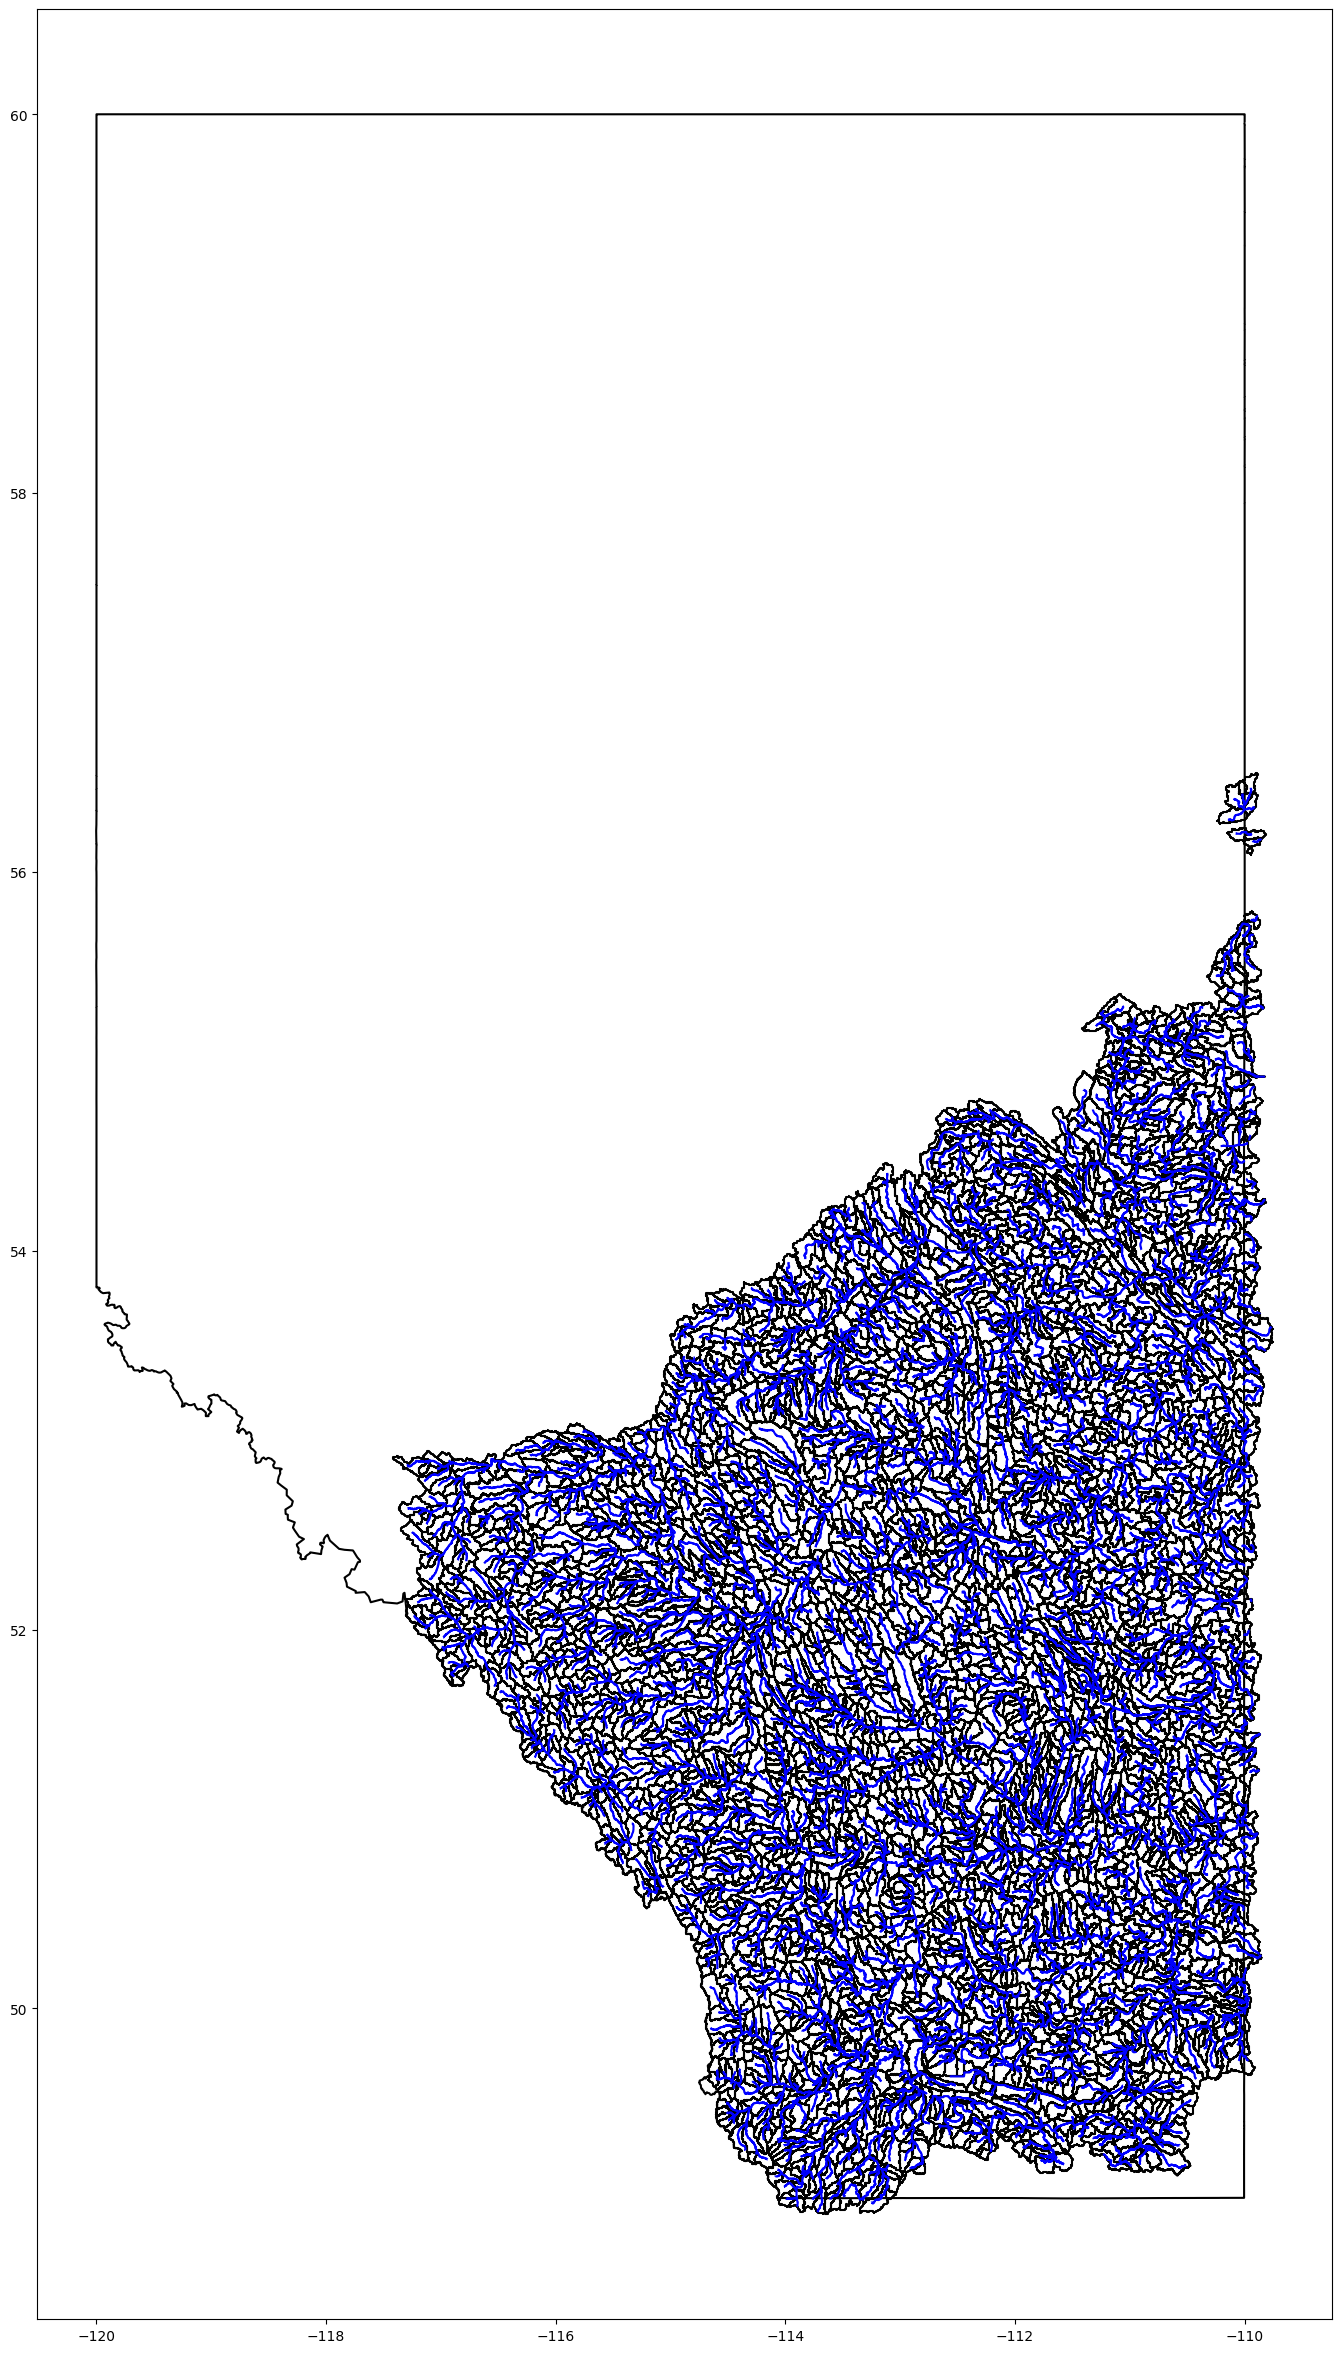

In [8]:
fig, ax = plt.subplots(figsize=(20,30))
trg_provinces.boundary.plot(ax=ax, color='k')
cat.boundary.plot(ax=ax,color='k')
riv.plot(ax=ax,color='blue')


In [9]:
def get_segment(riv,
                station_info,
                riv_col_seg,
                station_col_name = {'lat':'lat', 'lon':'lon', 'up_area':'up_area'},
                riv_col_up_area = None,
                riv_scale_up_area = None, # km2 to m2
                station_scale_up_area = None, # km2 to m2
                tolerance_for_area_diff = 0.05):

    # 
    if riv_col_up_area is not None:
        if riv_scale_up_area is not None:
            riv[riv_col_up_area] = riv[riv_col_up_area]*riv_scale_up_area

    # rename station
    station_info = station_info.rename(columns = station_col_name)
    print(station_info)

    if station_scale_up_area is not None:
        station_info.loc ['up_area'] = station_info.loc ['up_area'] * station_scale_up_area

    # 
    riv['lat_centroid'] = riv.centroid.y
    riv['lon_centroid'] = riv.centroid.x

    station_info['seg_id'] = np.NaN
    # loop over the station_info get the lat and lon and if available upstream area
    for index, row in station_info.iterrows():
        print(row)
        riv_temp = riv.copy()
        riv_temp['dist'] = 0
        riv_temp['dist'] = (riv['lat_centroid']-row['lat'])**2 + (riv['lon_centroid']-row['lon'])**2
        if (tolerance_for_area_diff is not None) and (riv_col_up_area is not None) and ('up_area' in station_col_name.keys()):
            riv_temp['area_within'] = riv_temp[riv_col_up_area].abs()/row.up_area.item()
            riv_temp = riv_temp [riv_temp ['area_within'] < tolerance_for_area_diff]
        if not riv_temp.empty: # pass Nan
            riv_temp = riv_temp.sort_values(by='dist')
            riv_temp = riv_temp.reset_index(drop=True)
            station_info['seg_id'].iloc[index] = riv_temp[riv_col_seg].iloc[0]

    return station_info
        
    

In [10]:
station_info = pd.read_csv('../../data/stations/Bow_at_Calagary.csv')

print(station_info)

station_info = get_segment(riv,
                station_info,
                'COMID',
                station_col_name = {'Latitude':'lat', 'Longitude':'lon'},
                riv_col_up_area = None,
                riv_scale_up_area = None, # km2 to m2
                station_scale_up_area = None, # km2 to m2
                tolerance_for_area_diff = 0.05)


  Station ID  Site type Data type (ID_type_****.csv)  \
0    05BH004  Regulated  05BH004_Annual_Flow_tab.csv   
1    05CC002  Regulated  05CC002_Annual_Flow_tab.csv   

                 Station name  Latitude  Longitude  
0        BOW RIVER AT CALGARY   51.0503   -114.051  
1  RED DEER RIVER AT RED DEER   52.2705   -113.823  
  Station ID  Site type Data type (ID_type_****.csv)  \
0    05BH004  Regulated  05BH004_Annual_Flow_tab.csv   
1    05CC002  Regulated  05CC002_Annual_Flow_tab.csv   

                 Station name      lat      lon  
0        BOW RIVER AT CALGARY  51.0503 -114.051  
1  RED DEER RIVER AT RED DEER  52.2705 -113.823  
Station ID                                          05BH004
Site type                                         Regulated
Data type (ID_type_****.csv)    05BH004_Annual_Flow_tab.csv
Station name                           BOW RIVER AT CALGARY
lat                                                 51.0503
lon                                                -1

/tmp/ipykernel_30498/1791062934.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  riv['lat_centroid'] = riv.centroid.y
/tmp/ipykernel_30498/1791062934.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  riv['lon_centroid'] = riv.centroid.x
/tmp/ipykernel_30498/1791062934.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_info['seg_id'].iloc[index] = riv_temp[riv_col_seg].iloc[0]
/tmp/ipykernel_30498/1791062934.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

In [11]:
print(station_info)

  Station ID  Site type Data type (ID_type_****.csv)  \
0    05BH004  Regulated  05BH004_Annual_Flow_tab.csv   
1    05CC002  Regulated  05CC002_Annual_Flow_tab.csv   

                 Station name      lat      lon      seg_id  
0        BOW RIVER AT CALGARY  51.0503 -114.051  71027770.0  
1  RED DEER RIVER AT RED DEER  52.2705 -113.823  71023173.0  


In [12]:
cat_slice, riv_slice = gm.intersect_topology(cat=cat,\
                                             cat_cols={'id':'COMID'},\
                                             riv=riv,\
                                             riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                             outlet_id=71027770)



# upstream_set = rg.find_upstream(riv,
#                                 71027770,
#                                 'COMID',
#                                 'NextDownID')

# riv_slice = riv[riv['COMID'].isin(upstream_set)]
# cat_slice = cat[cat['COMID'].isin(upstream_set)]

<AxesSubplot:>

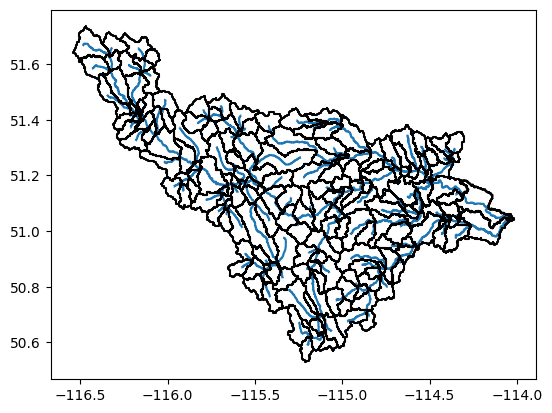

In [13]:
fig, ax = plt.subplots()
#trg_provinces.boundary.plot(ax=ax, color='k')
riv_slice.plot(ax=ax)
cat_slice.boundary.plot(ax=ax, color='k')

In [14]:
cat_slice.to_file(path_out+'Bow_at_Calgary_cat.shp')
riv_slice.to_file(path_out+'Bow_at_Calgary_riv.shp')

/tmp/ipykernel_30498/929435164.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  riv_slice.to_file(path_out+'Bow_at_Calgary_riv.shp')


In [15]:
riv_slice

,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,geometry,lat_centroid,lon_centroid
27769,71027770,2.040825,1.641712,1.243108,0.000978,9112.682461,4,2.0,0.000978,-9999,2,71027787,71027942,0,0,"LINESTRING (-114.01833 51.04417, -114.01917 51...",51.043969,-114.030198
27786,71027787,33.309245,15.747767,2.115173,0.002191,1252.709271,3,73.1,0.002191,71027770,2,71028199,71028359,0,0,"LINESTRING (-114.04167 51.04583, -114.04167 51...",51.008634,-114.140927
27941,71027942,28.145110,20.588731,1.367015,0.001798,7857.020581,4,50.7,0.001798,71027770,2,71027957,71030749,0,0,"LINESTRING (-114.04167 51.04583, -114.04250 51...",51.078911,-114.177198
27956,71027957,20.589551,13.558710,1.518548,0.001508,7669.065145,4,31.1,0.001508,71027942,2,71027962,71030189,0,0,"LINESTRING (-114.30750 51.12583, -114.30833 51...",51.160244,-114.396238
27961,71027962,2.160029,1.774091,1.217541,0.002403,7406.819260,4,5.2,0.002403,71027957,2,71027963,71028062,0,0,"LINESTRING (-114.48167 51.18000, -114.48250 51...",51.185731,-114.491914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39108,71039109,6.307484,4.937584,1.277443,0.017588,41.987611,1,111.1,0.017588,71036389,0,0,0,0,0,"LINESTRING (-115.51417 50.88583, -115.51500 50...",50.904078,-115.533883
39120,71039121,5.537017,4.428210,1.250396,0.028829,52.094426,1,160.0,0.028829,71035238,0,0,0,0,0,"LINESTRING (-115.13083 50.93000, -115.13167 50...",50.929122,-115.161885
39195,71039196,14.752598,10.106593,1.459700,0.008957,52.165900,1,132.4,0.008957,71028303,0,0,0,0,0,"LINESTRING (-114.57667 50.94583, -114.57750 50...",50.949999,-114.647416
39249,71039250,2.518299,2.040736,1.234015,0.032782,27.957672,1,82.7,0.032782,71028304,0,0,0,0,0,"LINESTRING (-115.09500 50.98083, -115.09417 50...",50.976350,-115.083124


In [16]:
import hydrant
hydrant.__file__

'/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/__init__.py'